In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import optuna
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

**Обработка датасета**

In [22]:
df = pd.read_csv("data.csv")
df.drop("Price for square meter", axis=1, inplace=True)
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)

In [23]:
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Level'] = pd.to_numeric(df['Level'], errors='coerce')
df['Levels count'] = pd.to_numeric(df['Levels count'], errors='coerce')
df['Ceiling height'] = pd.to_numeric(df['Ceiling height'], errors='coerce')
df['Total space'] = pd.to_numeric(df['Total space'], errors='coerce')
df['Living space'] = pd.to_numeric(df['Living space'], errors='coerce')
df['Kitchen space'] = pd.to_numeric(df['Kitchen space'], errors='coerce')

In [24]:
categorical_features = ['Building type', 'Advertisement type']

ohe = OneHotEncoder(sparse_output=False)
df_ohe = pd.DataFrame(ohe.fit_transform(df[categorical_features]), columns=ohe.get_feature_names_out(categorical_features))

df.reset_index(drop=True, inplace=True)
df_ohe.reset_index(drop=True, inplace=True)

df = pd.concat([df.drop(columns=categorical_features), df_ohe], axis=1)


**Удаляем выбросы**

*Удаляем значения, которые находятся за пределами трёх стандартных отклонений от среднего*

In [25]:
numeric_columns = ['Price', 'Level', 'Levels count', 'Ceiling height', 'Total space', 'Living space', 'Kitchen space']
def remove_outliers(df, columns):
    for column in columns:
        mean = df[column].mean()
        std_dev = df[column].std()
        df = df[(df[column] >= mean - 3 * std_dev) & (df[column] <= mean + 3 * std_dev)]
    return df

df_cleaned = remove_outliers(df, numeric_columns)

**Построение графиков**

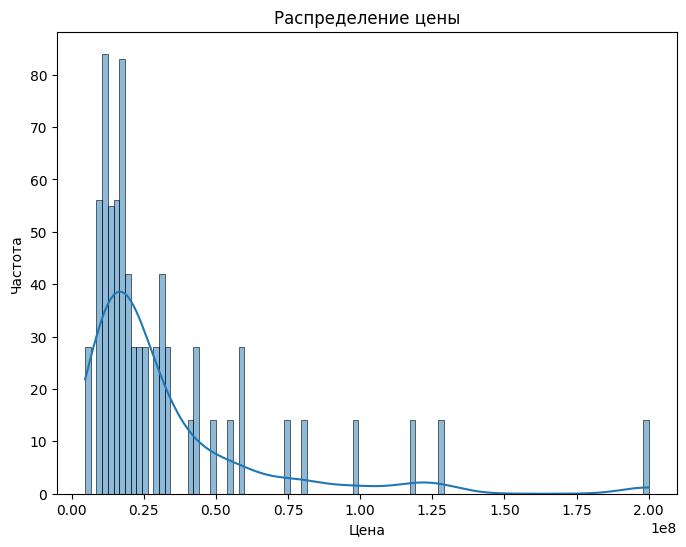

In [26]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Price'], bins=99, kde=True)
plt.title("Распределение цены")
plt.xlabel("Цена")
plt.ylabel("Частота")
plt.show()

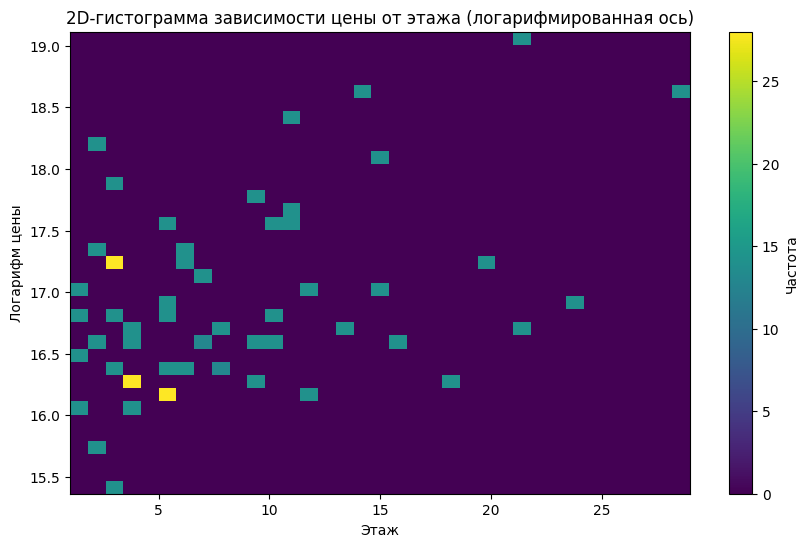

In [ ]:
df['Log Price'] = np.log1p(df['Price'])

df_cleaned = remove_outliers(df, ['Log Price', 'Level'])

plt.figure(figsize=(10, 6))
plt.hist2d(df_cleaned['Level'], df_cleaned['Log Price'], bins=(35, 35))
plt.colorbar(label='Частота')
plt.title('2D-гистограмма зависимости цены от этажа (логарифмированная ось)')
plt.xlabel('Этаж')
plt.ylabel('Логарифм цены')
plt.grid(visible=False)
plt.show()

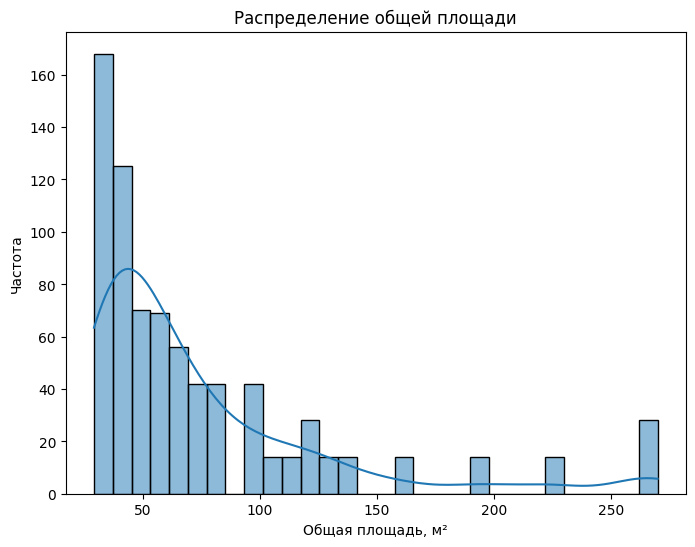

In [28]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Total space'], bins=30, kde=True)
plt.title("Распределение общей площади")
plt.xlabel("Общая площадь, м²")
plt.ylabel("Частота")
plt.show()

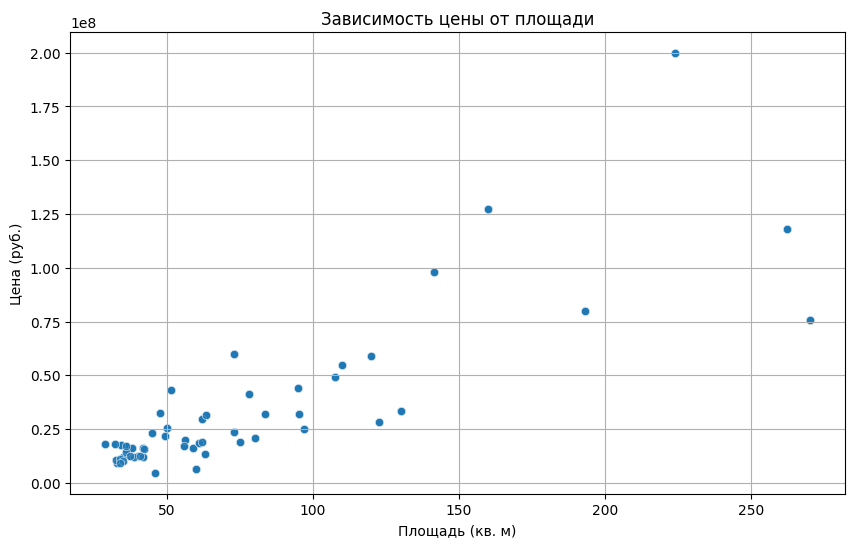

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Total space', y='Price', alpha=0.7)
plt.title('Зависимость цены от площади')
plt.xlabel('Площадь (кв. м)')
plt.ylabel('Цена (руб.)')
plt.grid()
plt.show()

**Разделение данных на обучающую, валидационную и тестовую выборки**

**X_train_full, y_train_full - обучающая выборка**

**X_train, y_train - валидационная выборка**

**X_test, y_test - тестовая выборка**

In [30]:
X = df.drop(columns='Price')
y = df['Price']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

**Baseline решение**

In [31]:
def simple_baseline(X):
    price_predictions = []
    for _, row in X.iterrows():
        if row['Total space'] < 50:
            price_predictions.append(18000000)  
        elif row['Total space'] < 100 and row['Level'] <= 10:
            price_predictions.append(23000000)  
        elif row['Total space'] < 100 and row['Level'] > 10:
             price_predictions.append(25000000)
        elif row['Total space'] < 150 and row['Level'] <= 10:
            price_predictions.append(36000000)
        elif row['Total space'] < 150 and row['Level'] > 10:
            price_predictions.append(49000000)
        else:
             price_predictions.append(125000000)
    return np.array(price_predictions)


y_pred_baseline = simple_baseline(X_test)

mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
mse_baseline = root_mean_squared_error(y_test, y_pred_baseline)

average_price = df['Price'].mean()

percentage_error = np.mean(np.abs((y_test - y_pred_baseline) / y_test)) * 100

print(f"Baseline (Simple if-else) - MAE: {mae_baseline:.2f}, MSE: {mse_baseline:.2f}")

print(f"Percentage error: {percentage_error:2f} %")

Baseline (Simple if-else) - MAE: 8586804.44, MSE: 14418114.99
Percentage error: 38.491375 %


**Модель из фреймворка**

**Масштабирование**

X_scaled = (X−μ) / 𝜎 

X — значение признака;

𝜇 — среднее значение признака;

𝜎 — стандартное отклонение признака.

In [32]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.to_numpy().reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1, 1)).flatten()


**Подбираем подбор гиперпараметров для библиотечной модели**

In [33]:
def objective(trial):
    max_iter = trial.suggest_int('max_iter', 1000, 2000)
    tol = trial.suggest_float('tol', 1e-5, 1e-3)
    alpha = trial.suggest_float('alpha', 1e-4, 1e-1, log=True)
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])
    
    model = SGDRegressor(max_iter=max_iter, tol=tol, alpha=alpha, penalty=penalty)
    model.fit(X_train_scaled, y_train_scaled)
    
    y_val_pred = model.predict(X_val_scaled)
    
    mse_val = root_mean_squared_error(y_val_scaled, y_val_pred)

    
    return mse_val


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  

best_params = study.best_params
print("Лучшие параметры:", best_params)


[I 2024-11-11 05:38:23,342] A new study created in memory with name: no-name-a8c7355d-7751-4de0-9056-9fe60a513f79
[I 2024-11-11 05:38:23,342] Trial 0 finished with value: 0.2717311871155469 and parameters: {'max_iter': 1465, 'tol': 0.0008632691981038485, 'alpha': 0.000176967884350462, 'penalty': 'l2'}. Best is trial 0 with value: 0.2717311871155469.
[I 2024-11-11 05:38:23,342] Trial 1 finished with value: 0.35786113730164215 and parameters: {'max_iter': 1882, 'tol': 0.00013324479283294375, 'alpha': 0.05213373016403291, 'penalty': 'l1'}. Best is trial 0 with value: 0.2717311871155469.
[I 2024-11-11 05:38:23,342] Trial 2 finished with value: 0.2736045253938836 and parameters: {'max_iter': 1176, 'tol': 0.000933910396197619, 'alpha': 0.00019838148240599858, 'penalty': 'elasticnet'}. Best is trial 0 with value: 0.2717311871155469.
[I 2024-11-11 05:38:23,360] Trial 3 finished with value: 0.27947707784931597 and parameters: {'max_iter': 1204, 'tol': 0.00012732911478275717, 'alpha': 0.02856181

Лучшие параметры: {'max_iter': 1902, 'tol': 0.0005033250198196601, 'alpha': 0.0032406504970791984, 'penalty': 'elasticnet'}


**Подставляем лучшие гиперпараметры и измеряем качество получившейся модели**

In [34]:
model = SGDRegressor(
    max_iter=best_params['max_iter'],
    tol=best_params['tol'],
    alpha=best_params['alpha'],
    penalty=best_params['penalty']
)
model.fit(X_train_scaled, y_train_scaled)
y_test_pred = model.predict(X_test_scaled)
y_test_pred_train = model.predict(X_train_scaled)
y_test_pred_val = model.predict(X_val_scaled)

    
mse_val_framework = root_mean_squared_error(y_test_scaled, y_test_pred)
mse_val_train_framework = root_mean_squared_error(y_train_scaled, y_test_pred_train)
mse_val_val_framework = root_mean_squared_error(y_val_scaled, y_test_pred_val)

y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_test_pred_original = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

percentage_error = np.mean(np.abs((y_test_original - y_test_pred_original) / y_test_original)) * 100

print(f"MSE on test: {mse_val_framework}")
print(f"MSE on train: {mse_val_train_framework}")
print(f"MSE on val: {mse_val_val_framework}")

print(f"Percentage error on test data: {percentage_error:.2f} %")


MSE on test: 0.2370363821102222
MSE on train: 0.23640078494698402
MSE on val: 0.27435710658859475
Percentage error on test data: 26.02 %


# **Строим график MSE (функции ошибки) от номера эпохи**

**Устанавливаем ***max_iter*** = 1, чтобы модель выполняла только одну итерацию обновления параметров за каждый вызов метода.**

**Используем ***partial_fit()***, чтобы поэтапно обновлять параметры модели.**


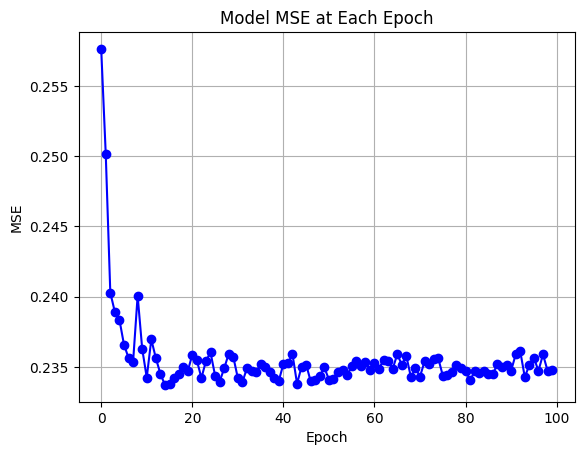

In [35]:
model = SGDRegressor(max_iter=1, tol=None, alpha=best_params['alpha'], penalty=best_params['penalty'])
mse_vals = []
n_epochs = 100

for epoch in range(n_epochs):
    model.partial_fit(X_train_scaled, y_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    mse_epoch = root_mean_squared_error(y_test_scaled, y_test_pred)
    mse_vals.append(mse_epoch)

plt.plot(range(n_epochs), mse_vals, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Model MSE at Each Epoch')
plt.grid(True)
plt.show()


**Собственная модель**

In [36]:
class LinearRegressionGD:
    def __init__(self, learning_rate=0.01, max_iter=1000):

        self.learning_rate = learning_rate
        self.max_iter = max_iter
    
    def fit(self, X_train, y_train):
        X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train]
        m, n = X_train.shape
        
        self.params = np.zeros(n)
        mses = []
        for _ in range(self.max_iter):
            mses.append(self._compute_mse(X_train, y_train))
            gradients = self._compute_gradient(X_train, y_train)
            if np.isnan(gradients).any():
                print(f"NaN в градиентах на итерации {i}: {gradients}")
                break
            self.params -= self.learning_rate * gradients
            if np.isnan(self.params).any():
                print(f"NaN в параметрах на итерации {i}: {self.params}")
                break
        return mses
    
    def predict(self, X_test):
        X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]  
        return np.dot(X_test, self.params)
    
    def _compute_mse(self, X, y):
        y_pred = np.dot(X, self.params)
        mse = np.mean((y - y_pred) ** 2)
        return mse
    
    def _compute_gradient(self, X, y):
        m = X.shape[0]
        y_pred = np.dot(X, self.params)
        gradients = (2 / m) * np.dot(X.T, (y_pred - y))
        return gradients

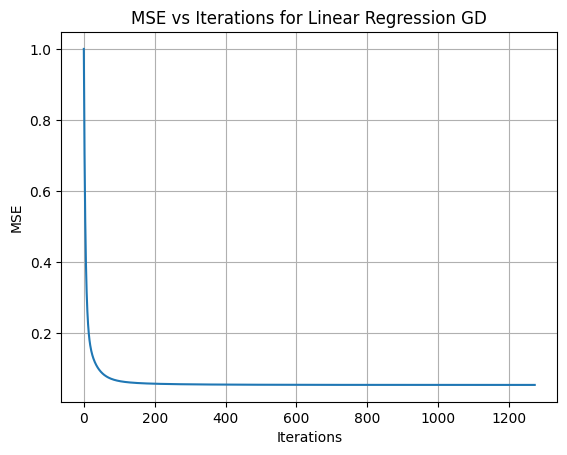

In [37]:
model = LinearRegressionGD(learning_rate=0.01, max_iter=1274)
mses = model.fit(X_train=X_train_scaled, y_train=y_train_scaled)
y_pred = model.predict(X_test=X_test_scaled)

plt.plot(range(len(mses)), mses)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('MSE vs Iterations for Linear Regression GD')
plt.grid(True)
plt.show()

**Подбор гиперпараметров**

In [38]:
def objective(trial):
    max_iter = trial.suggest_int('max_iter', 1000, 2000)
    learning_rate = trial.suggest_float('learning_rate', 1e-10, 1e-3)
    
    model = LinearRegressionGD(max_iter=max_iter, learning_rate=learning_rate)
    model.fit(X_train_scaled, y_train_scaled)
    
    y_val_pred = model.predict(X_val_scaled)
    
    mse_val = root_mean_squared_error(y_val_scaled, y_val_pred)

    
    return mse_val


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  

best_params = study.best_params
print("Лучшие параметры:", best_params)

[I 2024-11-11 05:38:24,481] A new study created in memory with name: no-name-9ead3139-22e3-450d-9f09-7a86b97905d5
[I 2024-11-11 05:38:24,544] Trial 0 finished with value: 0.8883027383929888 and parameters: {'max_iter': 1872, 'learning_rate': 1.6145736045435558e-05}. Best is trial 0 with value: 0.8883027383929888.
[I 2024-11-11 05:38:24,571] Trial 1 finished with value: 0.3872245866952042 and parameters: {'max_iter': 1400, 'learning_rate': 0.0002606514161670936}. Best is trial 1 with value: 0.3872245866952042.
[I 2024-11-11 05:38:24,645] Trial 2 finished with value: 0.29008790671844054 and parameters: {'max_iter': 1607, 'learning_rate': 0.0007253543269740215}. Best is trial 2 with value: 0.29008790671844054.
[I 2024-11-11 05:38:24,686] Trial 3 finished with value: 0.31751644975848575 and parameters: {'max_iter': 1312, 'learning_rate': 0.0005586357900754562}. Best is trial 2 with value: 0.29008790671844054.
[I 2024-11-11 05:38:24,730] Trial 4 finished with value: 0.5161814500635964 and p

Лучшие параметры: {'max_iter': 1824, 'learning_rate': 0.0009989724340490067}


**Обучение собственной модели с подобранными лучшими гиперпараметрами**

In [39]:
model = LinearRegressionGD(max_iter=best_params['max_iter'], learning_rate=best_params['learning_rate'])
model.fit(X_train_scaled, y_train_scaled)

y_test_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)

mse_test = root_mean_squared_error(y_test_scaled, y_test_pred)
mse_train = root_mean_squared_error(y_train_scaled, y_train_pred)
mse_val = root_mean_squared_error(y_val_scaled, y_val_pred)

y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_test_pred_original = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

percentage_error = np.mean(np.abs((y_test_original - y_test_pred_original) / y_test_original)) * 100

print(f"MSE на тестовом наборе: {mse_test}")
print(f"MSE на обучающем наборе: {mse_train}")
print(f"MSE на валидационном наборе: {mse_val}")

print(f"Percentage error on test data: {percentage_error:.2f} %")

MSE на тестовом наборе: 0.24351581170100936
MSE на обучающем наборе: 0.2427275986654023
MSE на валидационном наборе: 0.2774842730520942
Percentage error on test data: 26.10 %


**Сравнение результатов**

In [40]:
print(f"MSE на тестовом наборе (моя модель): {mse_test}")
print(f"MSE на тестовом наборе (модель из фреймворка): {mse_val_framework}")

MSE на тестовом наборе (моя модель): 0.24351581170100936
MSE на тестовом наборе (модель из фреймворка): 0.2370363821102222
